# Multi-Asset TOB Example

In this example we showcase a simple pairs trading strategy on one exchange. 

The strategy is based on the co-movement of two assets, UNI & SUSHI, and is heavily inspired by [this](https://github.com/jamesmawm/High-Frequency-Trading-Model-with-IB/blob/master/models/hft_model_1.py) model from James Ma. 

For it, we need two measures: 
- beta: $\beta = \frac{\mu_{SUSHI}}{\mu_{UNI}}$ where $\mu$ is the rolling average of the mid-price of an asset. The calculation used here is the one-pass EMA with a decay of 100. This beta between the two means is used to infer the mid-price of the SUSHI based on UNI. So $\overline{\text{SUSHI}} = \text{UNI} \times \beta$ where we have a trading decision.
- vol_ratio: $\gamma = \frac{\sigma_{SUSHI}}{\sigma_{UNI}}$

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.utils.one_pass_calculations import mean, var

%load_ext autoreload 
%autoreload 2

## Import data

In [2]:
folder_path = 'data_loader/datasets/'

In [3]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [24]:
symbols = ['SUSHIUSDT', 'UNIUSDT']

trades_list = []
quotes_list = []

for symbol in symbols: 
    # define folder path
    quotes_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'quotes']
    
    trades_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'trades']

In [25]:
quotes = get_data(quotes_list)
trades = get_data(trades_list)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


## Prepare Exchange

In [26]:
binance = TOB_Exchange(exchange_type = 'future')

In [27]:
usd_amount = 10_000
prices = quotes.groupby('symbol').ask_price.max()

per_asset = usd_amount // prices

In [28]:
for symbol in symbols: 
    binance.add_market(symbol, symbol[:-4], symbol[-4:])
    # binance.add_balance(symbol[:-4], per_asset[symbol])
    binance.add_balance(symbol[-4:], usd_amount)
    binance.load_tob(quotes.loc[quotes.symbol == symbol, ['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy(), symbol)
    binance.load_trades(trades.loc[trades.symbol == symbol, ['timestamp', 'id', 'side', 'price', 'amount']].to_numpy(), symbol)

2023-07-29 14:41:36,207 - INFO - src.exchange - Loading 284292 TOB-Updates for SUSHIUSDT
2023-07-29 14:41:36,782 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 14:41:36,827 - INFO - src.exchange - Loading 179322 trades for SUSHIUSDT
2023-07-29 14:41:37,773 - INFO - src.exchange - Trades loaded successfully
2023-07-29 14:41:37,828 - INFO - src.exchange - Loading 362406 TOB-Updates for UNIUSDT
2023-07-29 14:41:38,831 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 14:41:38,890 - INFO - src.exchange - Loading 297836 trades for UNIUSDT
2023-07-29 14:41:40,004 - INFO - src.exchange - Trades loaded successfully


## Spot Example

In [9]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.under = 1 if impl_mid < self.information[self.symbols[0]]['price'] else 0
        return [vol_ratio, beta, impl_mid, self.trend, self.under]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.under and self.trend and self.position <= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position += 1
        
        elif not self.under and not self.trend and self.position >= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position -= 1



    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [10]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)

In [11]:
strat.run_simulation()

2023-07-29 13:29:50,114 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477158, order_id=1, side=0, taker=True, amount=189.12529550827423, price=5.287, fees=0.19998108747044918, entryTime=1688170077624000.0, eventTime=1688170077627907.0)
2023-07-29 13:29:50,115 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477159, order_id=0, side=1, taker=True, amount=1447.7017734346725, price=0.6908, fees=0.20001447701773434, entryTime=1688170077624000.0, eventTime=1688170077629493.5)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477160, order_id=3, side=1, taker=True, amount=188.3771310162946, price=5.309, fees=0.20001883771310164, entryTime=1688171883825000.0, eventTime=1688171883829124.0)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477161, order_id=2, side=0, taker=True, amount=1452.3273545857237, price=0.6885, fees=0.19998547672645417, entryTi

In [13]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'asset_a', 'quote', 'asset_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind['asset_a'] * ind['price_a']
ind['usd_b'] = ind['asset_b'] * ind['price_b']
ind['combined'] = ind.usd_a + ind.quote + ind.usd_b
ind['log_bal'] = np.log(ind.combined / ind.combined.shift())

In [55]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

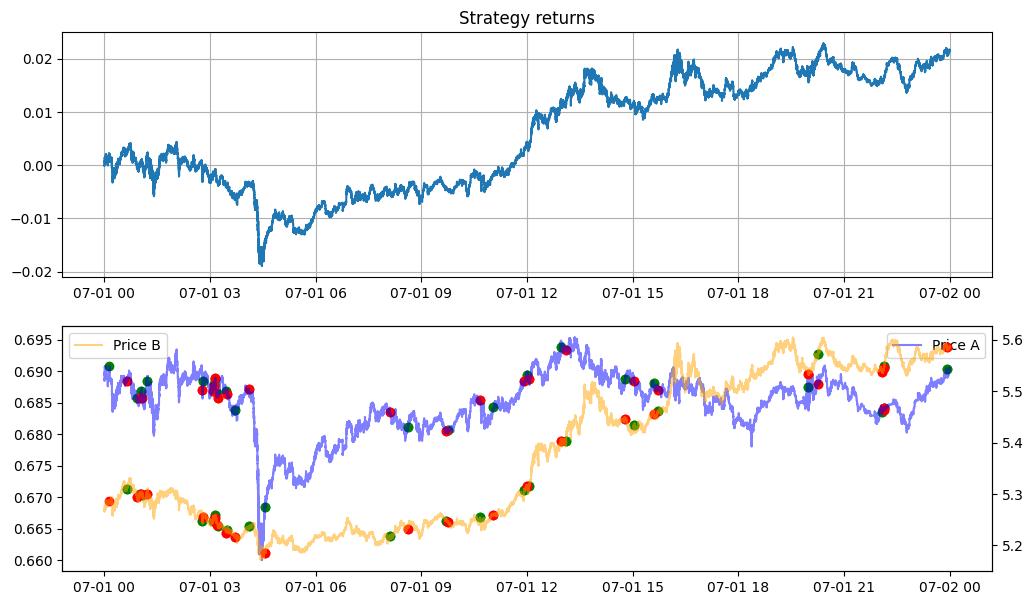

In [70]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.log_bal.cumsum(), label='change_midprice')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()

## Futures Example

Here we make an example with only having USDT in our account and trading on a futures exchange. This means that were handling positions and only adjust the balances in USD.

The strategy itself is the same with a small adjustment where we expect a minimum distance in percent that the implied midprice must be off. 

In [29]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.threshold = 0.04
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.opened = False

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.ema_diff = impl_mid / self.information[self.symbols[0]]['price'] - 1
        return [vol_ratio, beta, impl_mid, self.trend, self.ema_diff]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.ema_diff < -self.threshold and self.trend and self.position == 0: 
            print('enter long')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position = 1

        elif self.trend and self.position == -1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close short')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 1, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 0, ts)
            self.position = 0
        
        elif self.ema_diff > self.threshold and not self.trend and self.position == 0: 
            print('enter short')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position = -1

        elif not self.trend and self.position == 1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close long')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 0, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 1, ts)
            self.position = 0

    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()
            out += self.exchange.positions.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [30]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)
strat.run_simulation()

2023-07-29 14:41:42,492 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954360, order_id=45, side=0, taker=True, amount=188.76828692779614, price=5.297, fees=0.19998112317130723, entryTime=1688176012520000.0, eventTime=1688176012524723.0)
2023-07-29 14:41:42,493 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954361, order_id=44, side=1, taker=True, amount=1449.1703499746395, price=0.6901, fees=0.20001449170349977, entryTime=1688176012520000.0, eventTime=1688176012526013.5)


enter long


2023-07-29 14:41:42,859 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954362, order_id=47, side=1, taker=True, amount=188.76828692779614, price=5.266, fees=0.1988107597923549, entryTime=1688179492769000.0, eventTime=1688179492772455.5)
2023-07-29 14:41:42,860 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954363, order_id=46, side=0, taker=True, amount=1449.1703499746395, price=0.6902, fees=0.20004347511049927, entryTime=1688179492769000.0, eventTime=1688179492773652.2)


close long


2023-07-29 14:41:43,880 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954364, order_id=48, side=1, taker=True, amount=1477.5413711583926, price=0.6769, fees=0.20002955082742319, entryTime=1688187063216000.0, eventTime=1688187063220247.8)
2023-07-29 14:41:43,881 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954365, order_id=49, side=0, taker=True, amount=191.4425193835551, price=5.223, fees=0.19998085574806165, entryTime=1688187063216000.0, eventTime=1688187063222930.2)


enter long


2023-07-29 14:41:44,869 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954366, order_id=51, side=1, taker=True, amount=191.4425193835551, price=5.219, fees=0.19982770173255485, entryTime=1688198803641000.0, eventTime=1688198803644369.8)
2023-07-29 14:41:44,869 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954367, order_id=50, side=0, taker=True, amount=1477.5413711583926, price=0.6835, fees=0.20197990543735228, entryTime=1688198803641000.0, eventTime=1688198803647513.8)
2023-07-29 14:41:44,939 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954368, order_id=52, side=0, taker=True, amount=1465.845793022574, price=0.6821, fees=0.19997068308413957, entryTime=1688199463647000.0, eventTime=1688199463651190.8)
2023-07-29 14:41:44,940 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954369, order_id=53, side=1, taker=True, amount=191.07671730199678, price=5.234, fees=0.20001910767173026, entr

close long
enter short
close short


2023-07-29 14:41:46,141 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954372, order_id=57, side=1, taker=True, amount=186.89842070834501, price=5.351, fees=0.20001868984207083, entryTime=1688213256399000.0, eventTime=1688213256403337.5)
2023-07-29 14:41:46,142 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954373, order_id=56, side=0, taker=True, amount=1448.1210629208601, price=0.6905, fees=0.1999855187893708, entryTime=1688213256399000.0, eventTime=1688213256404441.8)


enter short


2023-07-29 14:41:46,617 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954374, order_id=58, side=1, taker=True, amount=1448.1210629208601, price=0.6938, fees=0.20094127869089856, entryTime=1688216245588000.0, eventTime=1688216245592508.8)
2023-07-29 14:41:46,618 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954375, order_id=59, side=0, taker=True, amount=186.89842070834501, price=5.404, fees=0.2019998131015793, entryTime=1688216245588000.0, eventTime=1688216245595328.2)
2023-07-29 14:41:46,705 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954376, order_id=60, side=0, taker=True, amount=1442.273022283118, price=0.6933, fees=0.19998557726977717, entryTime=1688216810681000.0, eventTime=1688216810684538.8)
2023-07-29 14:41:46,705 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954377, order_id=61, side=1, taker=True, amount=184.4167819271554, price=5.423, fees=0.20001844167819274, entry

close short
enter short


2023-07-29 14:41:47,486 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954378, order_id=63, side=0, taker=True, amount=184.4167819271554, price=5.443, fees=0.20075610880590136, entryTime=1688222615901000.0, eventTime=1688222615906776.2)
2023-07-29 14:41:47,486 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954379, order_id=62, side=1, taker=True, amount=1442.273022283118, price=0.6874, fees=0.19828369510348307, entryTime=1688222615901000.0, eventTime=1688222615907765.2)
2023-07-29 14:41:47,523 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954380, order_id=64, side=1, taker=True, amount=1449.905756125852, price=0.6898, fees=0.20002899811512254, entryTime=1688223030253000.0, eventTime=1688223030258113.2)
2023-07-29 14:41:47,523 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954381, order_id=65, side=0, taker=True, amount=184.07731247123792, price=5.432, fees=0.1999815922687529, entryT

close short
enter long
close long
enter short
close short


2023-07-29 14:41:47,851 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954388, order_id=72, side=0, taker=True, amount=1456.7703401558745, price=0.6864, fees=0.19998543229659846, entryTime=1688227146391000.0, eventTime=1688227146396259.8)
2023-07-29 14:41:47,851 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954389, order_id=73, side=1, taker=True, amount=182.4817518248175, price=5.481, fees=0.20003649635036497, entryTime=1688227146391000.0, eventTime=1688227146396863.2)


enter short


2023-07-29 14:41:49,661 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954390, order_id=74, side=1, taker=True, amount=1456.7703401558745, price=0.6875, fees=0.20030592177143275, entryTime=1688241511052000.0, eventTime=1688241511056083.8)
2023-07-29 14:41:49,661 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954391, order_id=76, side=1, taker=True, amount=1454.6512473634446, price=0.6875, fees=0.20001454651247363, entryTime=1688241511053000, eventTime=1688241511056880.2)
2023-07-29 14:41:49,661 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954392, order_id=75, side=0, taker=True, amount=182.4817518248175, price=5.534, fees=0.201970802919708, entryTime=1688241511052000.0, eventTime=1688241511057166.8)
2023-07-29 14:41:49,661 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954393, order_id=77, side=0, taker=True, amount=180.68479537446925, price=5.534, fees=0.19998193152046256, entryTi

close short
enter long


2023-07-29 14:41:49,916 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954394, order_id=78, side=0, taker=True, amount=1454.6512473634446, price=0.688, fees=0.20016001163720998, entryTime=1688242543930000.0, eventTime=1688242543933878.0)
2023-07-29 14:41:49,916 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954395, order_id=79, side=1, taker=True, amount=180.68479537446925, price=5.573, fees=0.20139127292438344, entryTime=1688242543930000.0, eventTime=1688242543936074.0)
2023-07-29 14:41:49,941 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954396, order_id=81, side=1, taker=True, amount=179.00295354873356, price=5.587, fees=0.20001790029535488, entryTime=1688242690470000.0, eventTime=1688242690472693.5)
2023-07-29 14:41:49,942 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954397, order_id=80, side=0, taker=True, amount=1453.594011192674, price=0.6879, fees=0.1999854640598881, entry

close long
enter short


2023-07-29 14:41:50,262 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954398, order_id=83, side=0, taker=True, amount=179.00295354873356, price=5.561, fees=0.19908708493690147, entryTime=1688246375236000.0, eventTime=1688246375239596.2)
2023-07-29 14:41:50,262 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954399, order_id=82, side=1, taker=True, amount=1453.594011192674, price=0.6864, fees=0.19954938585653031, entryTime=1688246375236000.0, eventTime=1688246375240723.2)


close short


2023-07-29 14:41:50,468 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954400, order_id=84, side=0, taker=True, amount=1462.3089858887183, price=0.6838, fees=0.19998537691014112, entryTime=1688249394717000.0, eventTime=1688249394720428.5)
2023-07-29 14:41:50,468 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954401, order_id=85, side=1, taker=True, amount=179.6138302649304, price=5.568, fees=0.20001796138302652, entryTime=1688249394717000.0, eventTime=1688249394721735.0)


enter short


2023-07-29 14:41:50,919 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=954402, order_id=87, side=0, taker=True, amount=179.6138302649304, price=5.586, fees=0.20066457117198028, entryTime=1688255698068000.0, eventTime=1688255698072420.0)
2023-07-29 14:41:50,919 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=954403, order_id=86, side=1, taker=True, amount=1462.3089858887183, price=0.6903, fees=0.20188637859179648, entryTime=1688255698068000.0, eventTime=1688255698072894.2)


close short


In [37]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'quote', 'position_a', 'position_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind.price_a * ind.position_a
ind['usd_b'] = ind.price_b * ind.position_b

<Axes: xlabel='ts'>

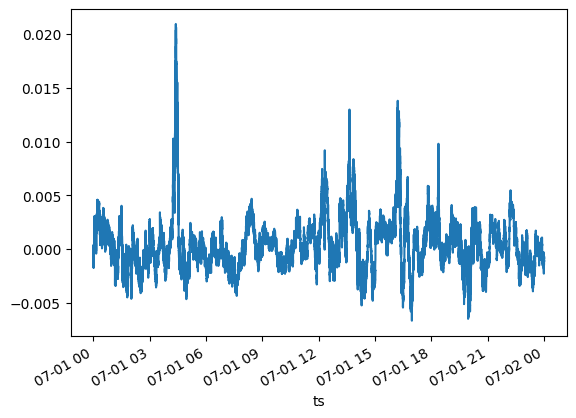

In [42]:
((ind.impl_mid / ind.price_a) - 1).plot()

In [38]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

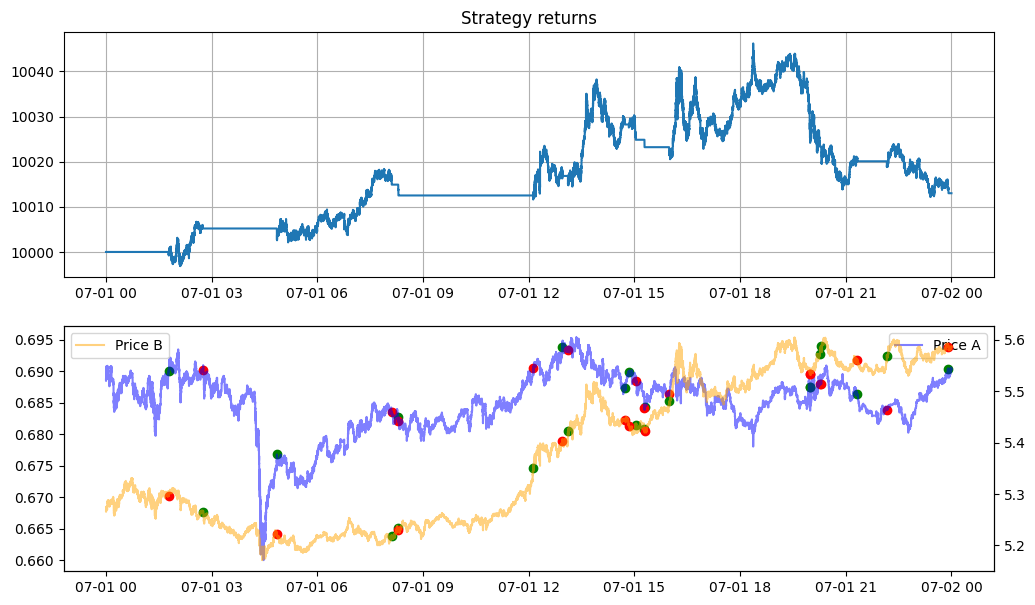

In [39]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.quote + ind.usd_a + ind.usd_b, label='Quote Balance')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()